# fig_brainPlots
### This notebook generates a brain plot showing electrode coverage for each subject, all electrodes (colored by region), all electrodes (colored by cluster), and for specific clusters. it saves brain plots as html pages

In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
from sklearn.metrics import r2_score,pairwise_distances
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['font.size'] = 12
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/brainPlots/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
def clean_fig(apply_int=True):
    plt.gca().set_yticks(np.linspace(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],3))
    plt.gca().set_xticks(np.linspace(plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],3))
    if apply_int==True:
        plt.gca().set_yticklabels(plt.gca().get_yticks().astype('int'),fontsize=20)
        plt.gca().set_xticklabels(plt.gca().get_xticks().astype('int'),fontsize=20)
    else:
        plt.gca().set_yticklabels(np.round(plt.gca().get_yticks(),2),fontsize=20)
        plt.gca().set_xticklabels(np.round(plt.gca().get_xticks(),2),fontsize=20)

# Collect Group Data
C = cc.Collection(collection_lbl='all')

# get task stats
C.doTaskStats_2d(pow_frange_lbl = 'HFA',
pow_method = 'wave',
pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
do_zscore = True,
apply_gauss_smoothing = True,
gauss_sd_scaling = 0.075,
apply_time_bins=False,num_iters=1000,
time_bin_size_ms=100,overwriteFlag =False,feat_list_beh=['zrrtStoch'])

# filter only include good electrodes 
C.filterElectrodes(filtE_bool= np.array(C.isBadElectrode_list)==False)


atlas='default'
#atlas='yeo'
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas=atlas);
#anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='yeo');

subj_list = np.unique(C.subj_list)



def plotSubjElecs(C,subj,marker_size=5,view_in_browser=True,plot_on_single_surface=True,save_fullpath=''):
    ret_idx  = (np.array(C.subj_list) == subj)
    
    

    colmap = cm.get_cmap('prism',100)
    
    #c_array = colmap(np.linspace(0,1,np.sum(ret_idx)))
    c_array = anatDf['roi_color'].to_numpy()
    

    C.evalClus_brainPlot(ret_idx=ret_idx,c=c_array,\
                         marker_size=marker_size,\
                         snap_to_surface = True,\
                         plot_on_single_surface=True,\
                         view_in_browser=view_in_browser,\
                         save_fullpath=save_fullpath)

    C.evalClus_brainPlot(ret_idx=ret_idx,c=c_array,\
                         marker_size=marker_size,\
                         snap_to_surface = True,\
                         plot_on_single_surface=False,\
                         view_in_browser=view_in_browser,\
                         save_fullpath=save_fullpath)

In [2]:
# plot subj by subj reports
# for s in subj_list:
#     #print(s)
#     plotSubjElecs(C,subj=s,view_in_browser=False,plot_on_single_surface=True,save_fullpath = fig_dir+s)
s ='HUP179'
# create a list of colors
plotSubjElecs(C,subj=s,marker_size=10,view_in_browser=True,plot_on_single_surface=True,save_fullpath = fig_dir+s)   

In [5]:
# plot all electrodes colored by region (exclude bad electrodes)
# get anatDf
#anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
C.evalClus_brainPlot(ret_idx=None,marker_size=5,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-ROI'+atlas)
C.evalClus_brainPlot(ret_idx=None,marker_size=5,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-ROI'+atlas)

total eligible electrodes 2609


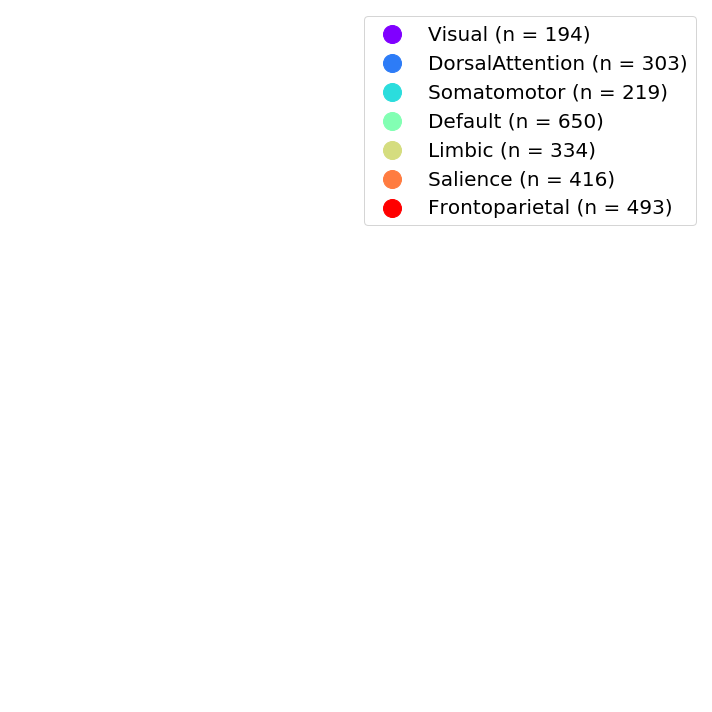

In [6]:
# plot legend
f = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
for r in roiList:
    roiCol = anatDf.query('roi==@r')['roi_color'][0]
    ax.scatter(roiList.index(r),roiList.index(r),color = roiCol,label=r+' (n = {count:n})'.format(count=np.sum(anatDf.eval('roi==@r'))))
ax.set_xlim(10,11)
ax.set_ylim(2,3)
ax.axis('off')
plt.legend(markerscale=3,fontsize=20)
plt.tight_layout()
print('total eligible electrodes',len(anatDf))
save_fig('roi_legend-'+atlas)

In [2]:
%%capture
# plot electrodes clustered by function
# cluster based on features
cut_level = 21
#cut_level = 12
C.clusterElectrodesByTaskStats(feat_option='selectivity',binarize_stats=True)
# plot each cluster (single surface)
clus_list,clus_color_list = C.evalClusLevel_brainPlot(clus_range=[1,22],use_anat_colors = True,cut_level = cut_level,plot_each_cluster = False, cmap='rainbow',marker_size=10,snap_to_surface = True,plot_on_single_surface=False,view_in_browser=True,\
                                                  plot_connectome=False,adj_linewidth=None,save_fullpath=fig_dir+'brainPlot-CLUS');


clus_list,clus_color_list = C.evalClusLevel_brainPlot(clus_range=[1,22],use_anat_colors = True,cut_level = 21,plot_each_cluster = False, cmap='rainbow',marker_size=10,snap_to_surface = True,plot_on_single_surface=True,view_in_browser=True,\
                                                  plot_connectome=False,adj_linewidth=None,save_fullpath=fig_dir+'brainPlot-CLUS');

In [11]:
#ad hoc plotting of individual clusters

# RT SELEC ONLY
# ClUSTER 3 (~MOTOR) 
ret_idx=np.array(C.clus_cut_tree[:,12]==3).astype('bool')
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
c_array = anatDf['roi_color'].to_numpy()
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=5,plot_on_single_surface=False,save_fullpath=fig_dir+'brainPlot-ANAT')

# ClUSTER 4 (~VISUAL) 
ret_idx=np.array(C.clus_cut_tree[:,12]==4).astype('bool')
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
c_array = anatDf['roi_color'].to_numpy()
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=5,plot_on_single_surface=False,save_fullpath=fig_dir+'brainPlot-ANAT')

# ClUSTER 5 (~SALIENCE) 
ret_idx=np.array(C.clus_cut_tree[:,12]==5).astype('bool')
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
c_array = anatDf['roi_color'].to_numpy()
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=5,plot_on_single_surface=False,save_fullpath=fig_dir+'brainPlot-ANAT')



In [4]:
# plot each cluster (single surface)
clus_list,clus_colors = C.evalClusLevel_brainPlot(cut_level = cut_level,plot_each_cluster = True, cmap='prism',marker_size=10,snap_to_surface = True,plot_on_single_surface=True,view_in_browser=True,\
                                                  plot_connectome=False,adj_linewidth=None,save_fullpath=fig_dir+'brainPlot-CLUS');

# plot each cluster (single surface)
clus_list,clus_colors = C.evalClusLevel_brainPlot(cut_level = cut_level,plot_each_cluster = True, cmap='prism',marker_size=10,snap_to_surface = True,plot_on_single_surface=False,view_in_browser=False,\
                                                  plot_connectome=False,adj_linewidth=None,save_fullpath=fig_dir+'brainPlot-CLUS');


# plot each cluster (Connectome)
clus_list,clus_colors = C.evalClusLevel_brainPlot(cut_level = cut_level,plot_each_cluster = True, cmap='prism',marker_size=10,snap_to_surface = True,plot_on_single_surface=True,view_in_browser=False,\
                                                  plot_connectome=True,adj_linewidth=None,save_fullpath=fig_dir+'brainPlot-CLUSConnect');
print(clus_list)

['12-0', '12-1', '12-2', '12-3', '12-4', '12-5', '12-6', '12-7', '12-8', '12-9', '12-11', '12-12']


In [5]:
%%capture
#plot legend (2d scatter of activation function)
postTarg_dict = C.evalClusLevel_activationAmplitude(clus_range=[1,22],cut_level = cut_level, figsize=(10,5),neu_feat = 'postTargOn');
preResp_dict = C.evalClusLevel_activationAmplitude(clus_range=[1,22],cut_level = cut_level, figsize=(10,5),neu_feat = 'preResponseL_respLocked');
anat_dict = C.evalClusLevel_anatLocalization(clus_range=[1,22],cut_level = cut_level)


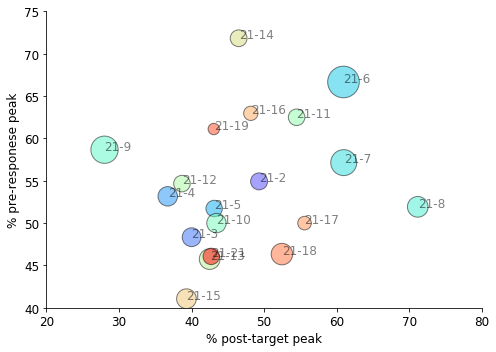

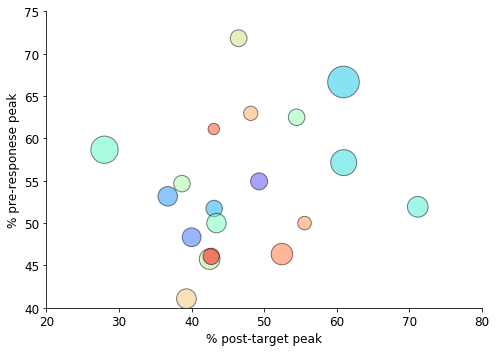

In [7]:
#f = plt.figure(figsize=(15,15))
#ax = plt.subplot(111)
alpha = 0.5
figsize = (7,5)
text_offset_x =0
text_offset_y = 0
xL=(10,80)
anat_scale = 20
#
# Descriptive
C.plot_scatter(postTarg_dict['freq']*100,preResp_dict['freq']*100,\
               s=anat_dict['chi2stats']*anat_scale,color=clus_color_list,cmap='magma',\
               plotLine=False,text_lbls=np.array(postTarg_dict['lbls']),alpha=alpha,\
               text_offset_x = text_offset_x,text_offset_y = text_offset_y, figsize=figsize)

#plt.gca().set_xlim(xL)
#plt.gca().set_ylim(-5,plt.gca().get_ylim()[1])
plt.gca().set_xlabel('% post-target peak')
plt.gca().set_ylabel('% pre-responese peak')
save_fig('clus_legend_scatter')


# Descriptive
C.plot_scatter(postTarg_dict['freq']*100,preResp_dict['freq']*100,\
               s=anat_dict['chi2stats']*anat_scale,color=clus_color_list,cmap='magma',\
               plotLine=False,text_lbls=None,alpha=alpha,\
               text_offset_x = text_offset_x,text_offset_y = text_offset_y, figsize=figsize)

#plt.gca().set_xlim(xL)
#plt.gca().set_ylim(-5,plt.gca().get_ylim()[1])
plt.gca().set_xlabel('% post-target peak')
plt.gca().set_ylabel('% pre-responese peak')
save_fig('clus_legend_scatter_noText')

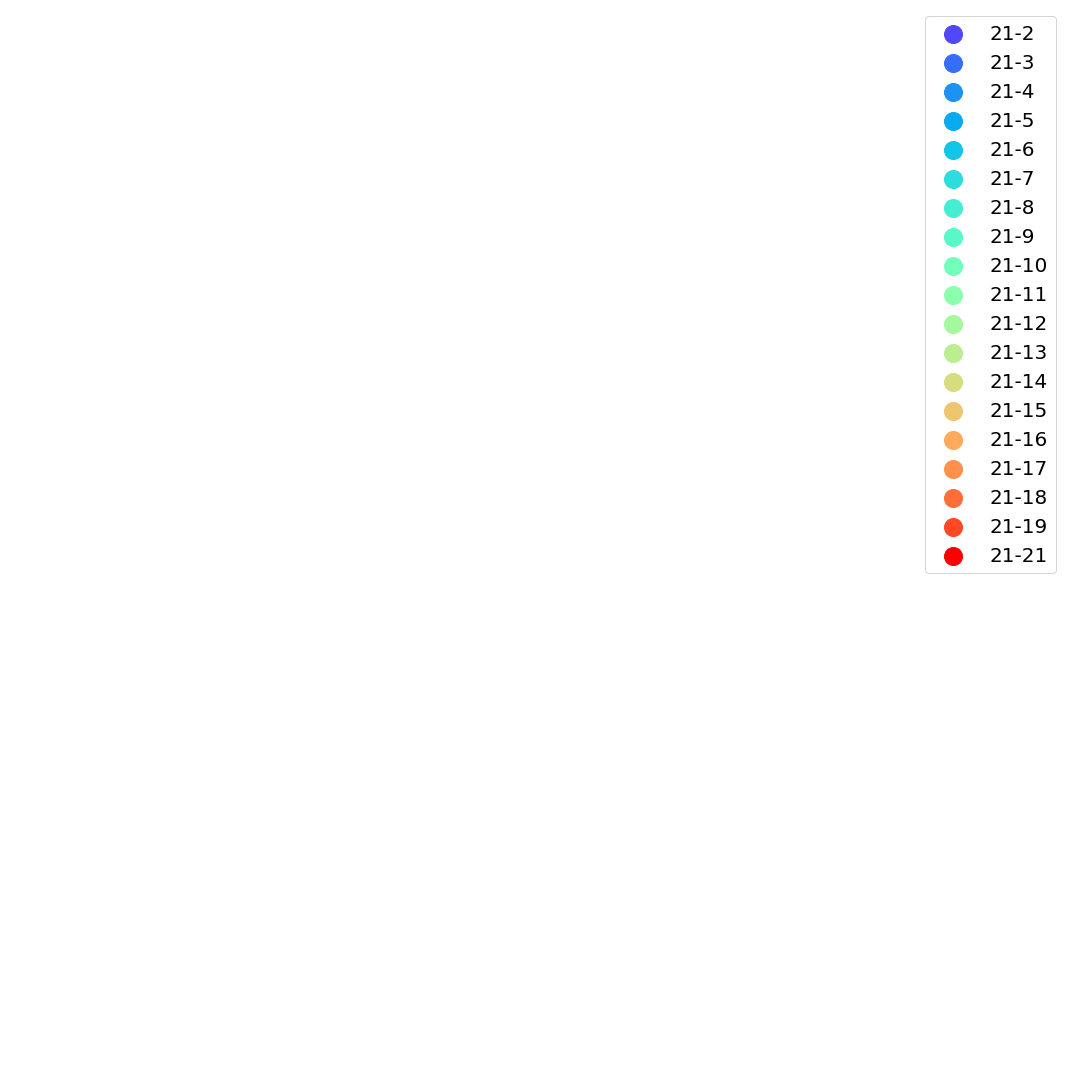

In [11]:
# plot legend
f = plt.figure(figsize=(15,15))
ax = plt.subplot(111)
for c in clus_list:
    ax.scatter(clus_list.index(c),clus_list.index(c),color = clus_color_list[clus_list.index(c)],label=c)
ax.set_xlim(10,11)
ax.set_ylim(2,3)
ax.axis('off')
plt.legend(markerscale=3,fontsize=20)
plt.tight_layout()
save_fig('clus_legend')

In [13]:
# Predictive vs. Reactive clusters
# Compare specific groups of clusters
min_subj = 5
min_elec = 50
cut_level = 21

# get clus_list
clus_list = C.clus_getEligibleClusters(cut_level=cut_level,\
                                       min_subj_thresh=min_subj,\
                                       min_elec_thresh=min_elec)

clus_list_a = [2,7,17,18]#
clus_list_b = [11,9,6,21] #


# any rt-related change
ret_idx_a = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_b = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in clus_list:
    ret_idx = C.clus_cut_tree[:,cut_level]==n
    if n in clus_list_a:        
        ret_idx_a = ret_idx_a|ret_idx
    if n in clus_list_b:
        ret_idx_b = ret_idx_b|ret_idx
        
# rainbow brain plot for each cluster       
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
C.evalClus_brainPlot(ret_idx=ret_idx_a,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-clusListA'+atlas)        
C.evalClus_brainPlot(ret_idx=ret_idx_b,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-clusListB'+atlas)  


# Brain plot with different colors for group and and group b
ret_idx=ret_idx_a|ret_idx_b
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
c_array = anatDf['roi_color'].to_numpy()

# update colors
def update_col(c_array,ret_idx_a,ret_idx_b,col1=(0,1,0,1),col2=(1,0,0,1)):
    
    for i in range(0,len(c_array)):
        if ret_idx_a[i]==True:
            c_array[i] = np.array(col1)
        elif ret_idx_b[i] == True:
            c_array[i] = np.array(col2)
            
    return c_array
    
        
c_array = update_col(c_array,ret_idx_a,ret_idx_b,col1=(0,1,0,1),col2=(1,0,0,1))      
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=10,plot_on_single_surface=False,save_fullpath=fig_dir+'brainPlot-clusListA-v-clusListB')
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=10,plot_on_single_surface=True,save_fullpath=fig_dir+'brainPlot-clusListA-v-clusListB')
        


In [19]:
# show localized effects (as positive controls)



# Compare spatial-selective and ~motor selective electrodes

ret_dict = C.groupElectrodesByTaskStats()

ret_idx_a = ret_dict['ret_idx_spatialSel']#&ret_dict['ret_idx_anat_left']
ret_idx_b = ret_dict['ret_idx_grp_motor']#ret_dict['ret_idx_grp_motor_left']



# rainbow brain plot for each cluster       
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
C.evalClus_brainPlot(ret_idx=ret_idx_a,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-spatial'+atlas)        
C.evalClus_brainPlot(ret_idx=ret_idx_b,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-motor'+atlas)  

# Brain plot with different colors for group and and group b
ret_idx=ret_idx_a|ret_idx_b
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
c_array = anatDf['roi_color'].to_numpy()

# update colors
def update_col(c_array,ret_idx_a,ret_idx_b,col1=(0,1,0,1),col2=(1,0,0,1)):
    
    for i in range(0,len(c_array)):
        if ret_idx_a[i]==True:
            c_array[i] = np.array(col1)
        elif ret_idx_b[i] == True:
            c_array[i] = np.array(col2)
            
    return c_array
    
        
c_array = update_col(c_array,ret_idx_a,ret_idx_b,col1=(0,0,1,1),col2=(1,0,1,1))      
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=10,plot_on_single_surface=False,save_fullpath=fig_dir+'brainPlot-spatial-v-motor')
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=10,plot_on_single_surface=True,save_fullpath=fig_dir+'brainPlot-spatial-v-motor')
        
        
#plot_dict_a = evalClus_wrapper2(ret_idx_a,beh_feat=beh_feat,yL = (-0.6,0.7),lbl='clus_list_a',atlas='default',binByRT = False,show_false_alarms = False)
#plot_dict_b = evalClus_wrapper2(ret_idx_b,beh_feat=beh_feat,yL = (-0.6,0.7),lbl='clus_list_b',atlas='default',binByRT = False,show_false_alarms = False)

In [32]:
#RT pos/neg over time

# get color array (will update as you go)
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow');
c_array = anatDf['roi_color'].to_numpy()

# update colors
def update_col(c_array,ret_idx_a,ret_idx_b,col1=(0,1,0,1),col2=(1,0,0,1)):
    
    for i in range(0,len(c_array)):
        if ret_idx_a[i]==True:
            c_array[i] = np.array(col1)
        elif ret_iwdx_b[i] == True:
            c_array[i] = np.array(col2)
            
    return c_array
    
        
#c_array = update_col(c_array,ret_idx_a,ret_idx_b,col1=(0,1,0,1),col2=(1,0,0,1)) 

# RT OVER TIME
beh_feat = 'zrrtStoch'
p_thresh=0.05
n_feat_list = ['S0f','S0c','postCC','postCC_bur','preResponse_bur','preResponse']
ret_idx_pos = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_neg = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in n_feat_list:
    is_neg = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()<0
    is_pos = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()>0
    is_sig = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh
    ret_idx_pos =  ret_idx_pos|(is_sig&is_pos)
    ret_idx_neg =  ret_idx_neg|(is_sig&is_neg)
    
    
    # update colors
    this_c_array = update_col(c_array,ret_idx_pos,ret_idx_neg,col1=(1,0,0,1),col2=(0,0,1,1)) 
    # (+/-) effects
    C.evalClus_brainPlot(ret_idx=is_sig,marker_size=10,plot_on_single_surface=True,c=this_c_array,\
                         save_fullpath=fig_dir+'brainPlot-rtCorr_'+n+'_PosNeg')
    C.evalClus_brainPlot(ret_idx=is_sig,marker_size=10,plot_on_single_surface=False,c=this_c_array,\
                         save_fullpath=fig_dir+'brainPlot-rtCorr_'+n+'_PosNeg')

    
# DELAY OVER TIME
beh_feat = 'zrrtStoch'
p_thresh=0.05
n_feat_list = ['S0c','postCC','postCC_bur','preResponse_bur','preResponse']
ret_idx_pos = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_neg = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in n_feat_list:
    is_neg = C.taskstats2d_df['delayDiff_'+n+'_zstatnp'].to_numpy()<0
    is_pos = C.taskstats2d_df['delayDiff_'+n+'_zstatnp'].to_numpy()>0
    is_sig = C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh
    ret_idx_pos =  ret_idx_pos|(is_sig&is_pos)
    ret_idx_neg =  ret_idx_neg|(is_sig&is_neg)
    
    
    # update colors
    this_c_array = update_col(c_array,ret_idx_pos,ret_idx_neg,col1=(1,0,0,1),col2=(0,0,1,1)) 
    # (+/-) effects
    C.evalClus_brainPlot(ret_idx=is_sig,marker_size=10,plot_on_single_surface=True,c=this_c_array,\
                         save_fullpath=fig_dir+'brainPlot-delayDiff_'+n+'_PosNeg')
    C.evalClus_brainPlot(ret_idx=is_sig,marker_size=10,plot_on_single_surface=False,c=this_c_array,\
                         save_fullpath=fig_dir+'brainPlot-delayDiff_'+n+'_PosNeg')

In [8]:
# plot RT-predictive electrodes on a brain plot

beh_feat = 'zrrtStoch'
p_thresh=0.05
ret_idx = C.taskstats2d_df['rtRegress_multivar_'+beh_feat+'_SSE_pvalnp'].to_numpy()<p_thresh


# color maps onto p-value?
#colmap = cm.get_cmap('coolwarm',100)
#c_array = colmap(1-C.taskstats2d_df['rtRegress_multivar_'+beh_feat+'_SSE_pvalnp'].to_numpy()[ret_idx])
C.evalClus_brainPlot(ret_idx=ret_idx,marker_size=5,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                      save_fullpath=fig_dir+'brainPlot-rtPred')
C.evalClus_brainPlot(ret_idx=ret_idx,marker_size=5,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-rtPred')


In [9]:
# plot delay related activity
# any delay related difference
p_thresh=0.05
n_feat_list = ['S0c','postCC','postCC_bur','preResponse_bur','preResponse']

# any delay-related change
ret_idx = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in n_feat_list:
    ret_idx =  ret_idx|(C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh)

C.evalClus_brainPlot(ret_idx=ret_idx,marker_size=5,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                      save_fullpath=fig_dir+'brainPlot-delayDiff')
C.evalClus_brainPlot(ret_idx=ret_idx,marker_size=5,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-delayDiff')

In [4]:
# plot anticipatory timing selective electrodes

beh_feat = 'zrrtStoch'
p_thresh=0.05
ret_idx = C.taskstats2d_df['ptCorr_S0f_pval'].to_numpy()<p_thresh


# color maps onto p-value?
#colmap = cm.get_cmap('coolwarm',100)
#c_array = colmap(1-C.taskstats2d_df['rtRegress_multivar_'+beh_feat+'_SSE_pvalnp'].to_numpy()[ret_idx])

C.evalClus_brainPlot(ret_idx=ret_idx,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-ptCorr')

/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [5]:
# plot rtCorr by feature selective electrodes

beh_feat = 'zrrtStoch'
p_thresh=0.05
n_feat_list = ['S0f','S0c','postCC','postCC_bur','preResponse_bur','preResponse']
ret_idx_pos = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_neg = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in n_feat_list:
    is_neg = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()<0
    is_pos = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()>0
    is_sig = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh
    ret_idx_pos =  ret_idx_pos|(is_sig&is_pos)
    ret_idx_neg =  ret_idx_neg|(is_sig&is_neg)
    # (-) effects
    C.evalClus_brainPlot(ret_idx=is_sig&is_neg,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                         save_fullpath=fig_dir+'brainPlot-rtCorr_'+n+'_neg')
    C.evalClus_brainPlot(ret_idx=is_sig&is_neg,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                         save_fullpath=fig_dir+'brainPlot-rtCorr_'+n+'_neg')
    # (+) effects
    C.evalClus_brainPlot(ret_idx=is_sig&is_pos,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                         save_fullpath=fig_dir+'brainPlot-rtCorr_'+n+'_pos')
    C.evalClus_brainPlot(ret_idx=is_sig&is_pos,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                         save_fullpath=fig_dir+'brainPlot-rtCorr_'+n+'_pos')

# any pos
C.evalClus_brainPlot(ret_idx=ret_idx_pos,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-rtCorr_ANY_posCorr')
C.evalClus_brainPlot(ret_idx=ret_idx_pos,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-rtCorr_ANY_posCorr')


# any neg
C.evalClus_brainPlot(ret_idx=ret_idx_neg,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-rtCorr_ANY_negCorr')
C.evalClus_brainPlot(ret_idx=ret_idx_neg,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-rtCorr_ANY_negCorr')


# no correlation
C.evalClus_brainPlot(ret_idx=(ret_idx_pos==False)&(ret_idx_neg==False),marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-rtCorr_ANY_noCorr')
C.evalClus_brainPlot(ret_idx=(ret_idx_pos==False)&(ret_idx_neg==False),marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-rtCorr_ANY_noCorr')

In [6]:
# plot delay diff brain plots for specific features
beh_feat = 'zrrtStoch'
p_thresh=0.05
n_feat_list = ['S0c','postCC','postCC_bur','preResponse_bur','preResponse']
ret_idx_pos = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_neg = np.zeros(len(C.taskstats2d_df)).astype('bool')
for n in n_feat_list:
    is_neg = C.taskstats2d_df['delayDiff_'+n+'_zstatnp'].to_numpy()<0
    is_pos = C.taskstats2d_df['delayDiff_'+n+'_zstatnp'].to_numpy()>0
    is_sig = C.taskstats2d_df['delayDiff_'+n+'_pvalnp'].to_numpy()<p_thresh
    ret_idx_pos =  ret_idx_pos|(is_sig&is_pos)
    ret_idx_neg =  ret_idx_neg|(is_sig&is_neg)    
    # (-) effects
    C.evalClus_brainPlot(ret_idx=is_sig&is_neg,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                         save_fullpath=fig_dir+'brainPlot-delayDiff_'+n+'_neg')
    C.evalClus_brainPlot(ret_idx=is_sig&is_neg,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                         save_fullpath=fig_dir+'brainPlot-delayDiff_'+n+'_neg')
    # (+) effects
    C.evalClus_brainPlot(ret_idx=is_sig&is_pos,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                         save_fullpath=fig_dir+'brainPlot-delayDiff_'+n+'_pos')
    C.evalClus_brainPlot(ret_idx=is_sig&is_pos,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                         save_fullpath=fig_dir+'brainPlot-delayDiff_'+n+'_pos')
    
# any pos
C.evalClus_brainPlot(ret_idx=ret_idx_pos,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-delayDiff_ANY_posEffect')
C.evalClus_brainPlot(ret_idx=ret_idx_pos,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-delayDiff_ANY_posEffect')


# any neg
C.evalClus_brainPlot(ret_idx=ret_idx_neg,marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-delayDiff_ANY_negEffect')
C.evalClus_brainPlot(ret_idx=ret_idx_neg,marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-delayDiff_ANY_negEffect')


# no correlation
C.evalClus_brainPlot(ret_idx=(ret_idx_pos==False)&(ret_idx_neg==False),marker_size=10,plot_on_single_surface=True,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-delayDiff_ANY_noEffect')
C.evalClus_brainPlot(ret_idx=(ret_idx_pos==False)&(ret_idx_neg==False),marker_size=10,plot_on_single_surface=False,c=anatDf['roi_color'].to_numpy(),\
                     save_fullpath=fig_dir+'brainPlot-delayDiff_ANY_noEffect')